In [1]:
import math
import mediapipe as mp
import cv2
import numpy as np
import skatePoseModule as spm
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import random
import pandas as pd
import os

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

psd = spm.poseDetector(min_detection_confidence=0.2, min_tracking_confidence=0.8, model_complexity=2)

In [24]:
# open video file
video_path = './kakao/101_2.mp4'
cap = cv2.VideoCapture(video_path)
fit_to = 'width'

# check file is opened
if not cap.isOpened():
    exit()
    
lmlist = []
rightLegAngleList = []
leftLegAngleList = []
rightGolbanAngleList = []
leftGolbanAngleList = []
leftArmAngleList = []
rightArmAngleList = []

vis = []
visList = []

In [25]:
# initialize tracker
OPENCV_OBJECT_TRACKERS = {
  "csrt": cv2.TrackerCSRT_create
}

tracker = OPENCV_OBJECT_TRACKERS['csrt']()

# global variables
top_bottom_list, left_right_list = [], []
count = 0

In [26]:
# main
flag=0
while True:
    ret, img = cap.read()
    
    if not ret:
        continue
    
    while True:
        cv2.namedWindow('Select Window')
        cv2.imshow('Select Window', img)
        os.system("pause")
        
        key = cv2.waitKeyEx(0)
        
        if key == 27:
            cap = cv2.VideoCapture(video_path)
            break
        elif key == 2555904:
            break
        elif key == 13:
            # select ROI
            rect = cv2.selectROI('Select Window', img, fromCenter=False, showCrosshair=True)
            cv2.destroyWindow('Select Window')
            flag=1
            break
            
    if flag==1:
        break
    else:
        continue
        
scale = 1.3
frame_list = []
frame_num = 1

output_size = (int(rect[2]*scale), int(rect[3]*scale)) # (width, height)

# initialize tracker
tracker.init(img, rect)

with mp_pose.Pose(min_detection_confidence=0.1, min_tracking_confidence=0.9, model_complexity=2) as pose:
    while True:
        count += 1
        # read frame from video
        ret, img = cap.read()

        if not ret:
            break
        # update tracker and get position from new frame
        success, box = tracker.update(img)
        # if success:
        left, top, w, h = [int(v) for v in box]
        right = left + w
        bottom = top + h

        center_x = left+w/2
        center_y = top+h/2
        
        result_top = int(center_y - output_size[1] / 2)
        result_bottom = int(center_y + output_size[1] / 2)
        result_left = int(center_x - output_size[0] / 2)
        result_right = int(center_x + output_size[0] / 2)
        
        if result_top<0:
            result_top=0
            
        if result_bottom<0:
            result_bottom=0
            
        if result_left<0:
            result_left=0
            
        if result_right<0:
            result_right=0
        
        # crop image
        result_img = img[result_top:result_bottom, result_left:result_right].copy()

        # resize image to output size
        result_img = cv2.resize(result_img, output_size)

        # BGR to RGB
        image = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        cv2.rectangle(img, pt1=(left, top), pt2=(right, bottom), color=(255,255,255),
                     thickness=3)
        
        # Make detection
        results = pose.process(image)

        # RGB to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
        except:
            pass

        # Save landmarks
        if results.pose_landmarks is not None:
            mypose = results.pose_landmarks
            tmpList = []
            for idx,lm in enumerate(mypose.landmark):
                point=np.array([int(idx), lm.x, lm.y, lm.z])
                tmpList.append(point)
            
            rightLegAngleList.append(psd.findAngle3D(tmpList[24][1:],tmpList[26][1:],tmpList[28][1:]))
            leftLegAngleList.append(psd.findAngle3D(tmpList[23][1:],tmpList[25][1:],tmpList[27][1:]))
            rightGolbanAngleList.append(psd.findAngle3D(tmpList[12][1:],tmpList[24][1:],tmpList[26][1:]))
            leftGolbanAngleList.append(psd.findAngle3D(tmpList[11][1:],tmpList[23][1:],tmpList[25][1:]))    

            lmlist.append(tmpList)
            
            frame_list.append(frame_num)
            frame_num += 1
            
            a = abs(psd.findAngle3D(tmpList[24][1:],tmpList[26][1:],tmpList[28][1:]) - psd.findAngle3D(tmpList[23][1:],tmpList[25][1:],tmpList[27][1:]))
            b = abs(psd.findAngle3D(tmpList[12][1:],tmpList[24][1:],tmpList[26][1:]) - psd.findAngle3D(tmpList[11][1:],tmpList[23][1:],tmpList[25][1:]))
            vis.append(a+b)
            
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                      mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                      mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                     )

        # visualize
        pt1 = (int(left), int(top))
        pt2 = (int(right), int(bottom))
        cv2.rectangle(img, pt1, pt2, (255, 255, 255), 3)

        cv2.imshow('img', img)
        cv2.imshow('result', image)

        if cv2.waitKeyEx(1) == 27:
            break

# release everything
cap.release()
cv2.destroyAllWindows()

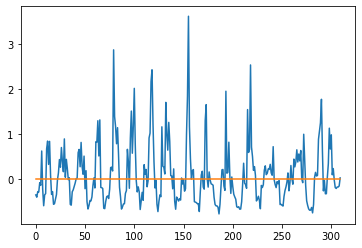

In [18]:
import math
import numpy as np

leftList = (np.array(leftGolbanAngleList) + np.array(leftLegAngleList))
rightList = (np.array(rightGolbanAngleList) + np.array(rightLegAngleList))
GLList = ((leftList / rightList)-1.01)

import matplotlib.pyplot as plt

start = 0
end = len(GLList)
y = range(start, end)
plt.plot(y, np.array(GLList)[start:end])
plt.plot(y, np.zeros_like(np.array(GLList)[start:end]))
plt.show()

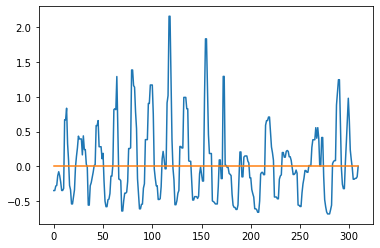

In [19]:
from scipy.signal import medfilt

GLList_med = medfilt(GLList, kernel_size=3)

import matplotlib.pyplot as plt

start = 0
end = len(GLList_med)
y = range(start, end)
plt.plot(y, np.array(GLList_med)[start:end])
plt.plot(y, np.zeros_like(np.array(GLList_med)[start:end]))
plt.show()

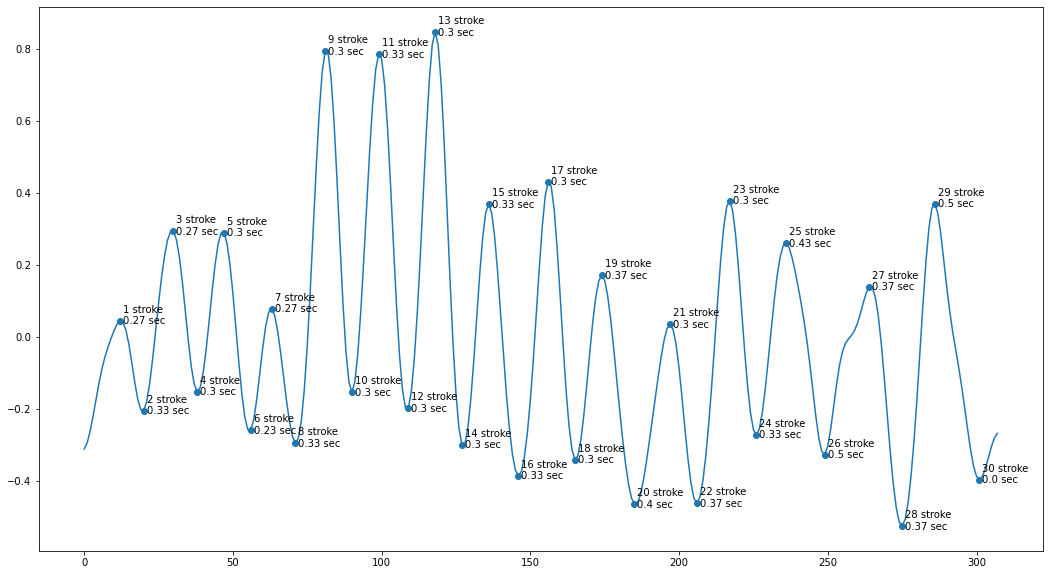

In [187]:
from scipy.ndimage import gaussian_filter1d

########variables#########
# GLList_gauss : GLList filtered by gaussian
# max_list : max points list
# max_local : # of max points 
# y_max : y for max points
# delay_list : calculated delay between current and one step later 
###########################

# gaussian filtering
for i in range(10):
    GLList_gauss = gaussian_filter1d(GLList, sigma=3.5)

GLList_gauss -= np.mean(GLList_gauss)    

# find max points
max_list = []
max_local=0
for u in range (1,len(GLList_gauss)-1):
    if ((GLList_gauss[u]>GLList_gauss[u-1])&(GLList_gauss[u]>GLList_gauss[u+1])):
        max_local=max_local+1
        max_list.append(frame_list[u]-1)
for u in range (1,len(GLList_gauss)-1):
    if ((GLList_gauss[u]<GLList_gauss[u-1])&(GLList_gauss[u]<GLList_gauss[u+1])):
        max_local=max_local+1
        max_list.append(frame_list[u]-1)

max_list.sort()

# find y for max points
y_max = []
for maxes in max_list:
    y_max.append(GLList_gauss[maxes])
    
    
# calc delay and append to delay_list
delay_list = []

for i in range(len(max_list)):
    if i != len(max_list)-1:
        delay_list.append((frame_list[max_list[i+1]] - frame_list[max_list[i]])/30)

delay_list.append(0.0)

# variables
start = 0
end = len(GLList_gauss)
y = range(start, end)

# draw 
plt.figure(figsize=(18,10))
plt.plot(y, np.array(GLList_gauss)[start:end])
plt.scatter(max_list, np.array(y_max))
for i, maxes in enumerate(max_list):
    plt.text(maxes+1, y_max[i]-0.01, str(i+1)+" strokes \n"+str(np.round(delay_list,2)[i])+" sec", fontsize=10)
plt.show()